In [2]:
# Basic system and data packages
import numpy as np
import pandas as pd
from collections import OrderedDict
import itertools
import statsmodels.formula.api as smf
import sys
import time
import requests
# Plotting packages
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
from io import BytesIO

In [3]:
df = pd.read_csv('../../../data/mobile-forecast/emissions-populations-dvmt.csv')
#Plot the data set
df

# Drop the first column
df = df.drop(columns=['Unnamed: 0'])

# Set the second column as the row index
df = df.set_index('Year')
df

,Mobile GHG Emissions (MMTCO2e),Agriculture GHG Emissions (MMTCO2e),Commercial GHG Emissions (MMTCO2e),Electricity GHG Emissions (MMTCO2e),Industrial GHG Emissions (MMTCO2e),Residential GHG Emissions (MMTCO2e),Solidwaste GHG Emissions (MMTCO2e),Wastewater GHG Emissions (MMTCO2e),Population,DVMT (Miles)
Year,,,,,,,,,,
1990,15.120625,0.375261,3.828568,11.908703,3.001041,8.279021,1.065912,0.359842,3289056,72072000
1991,15.005884,0.348502,3.662331,12.015808,3.100758,8.024783,1.113482,0.361827,3288640,72948000
1992,15.086747,0.389088,4.312955,11.282676,3.355918,9.505435,1.242805,0.362378,3274997,72293000
1993,15.146864,0.415000,3.843474,10.228667,3.447719,9.081525,1.209374,0.363307,3272325,74025000
1994,15.066461,0.408122,4.172272,10.395885,3.150548,8.677775,1.237386,0.365658,3268346,74352000
1995,14.815692,0.400748,3.841800,10.320433,3.103303,7.977389,1.249919,0.365747,3265293,76830000
1996,15.623592,0.344938,4.133427,10.734700,3.257568,8.461561,1.268976,0.367926,3267030,76874000
1997,15.679850,0.348057,4.301810,13.201970,3.266450,8.186120,1.615209,0.368520,3268514,78202000
1998,15.917011,0.375380,4.036593,12.948870,3.119599,7.122707,1.526577,0.371087,3272563,79936000


In [4]:
#split into training data and test data
split_index = round(len(df)*0.8)
df_train = df.iloc[:split_index].copy()
df_test = df.iloc[split_index:].copy()
df_test

,Mobile GHG Emissions (MMTCO2e),Agriculture GHG Emissions (MMTCO2e),Commercial GHG Emissions (MMTCO2e),Electricity GHG Emissions (MMTCO2e),Industrial GHG Emissions (MMTCO2e),Residential GHG Emissions (MMTCO2e),Solidwaste GHG Emissions (MMTCO2e),Wastewater GHG Emissions (MMTCO2e),Population,DVMT (Miles)
Year,,,,,,,,,,
2016,15.214360,0.339883,3.907677,9.289161,3.152446,6.380817,1.950564,0.394595,3579830,86444182
2017,15.325243,0.341291,3.920870,8.501146,3.123419,6.621179,1.868640,0.394567,3575324,86301543
2018,15.633220,0.350344,4.329612,8.066976,3.137983,7.595505,1.766990,0.394951,3574561,86563582
2019,15.399656,0.369979,4.196598,5.690000,3.146549,7.414013,1.860953,0.392797,3566022,86577672
2020,13.071437,0.346028,3.824505,3.200000,3.128899,6.665511,1.842936,0.391845,3597362,81543552
2021,14.766522,0.350000,4.001450,3.040000,3.376378,6.723916,1.850000,0.390000,3623355,79420671


In [5]:
elec_train = df_train['Electricity GHG Emissions (MMTCO2e)']
elec_test = df_test['Electricity GHG Emissions (MMTCO2e)']

In [12]:
exog1 = df_train['DVMT (Miles)']
exog2 = df_train['Population']
# Combine the exogenous variables
exog_combined = pd.concat([exog1, exog2], axis=1)

exog1_test = df_test['DVMT (Miles)']
exog2_test = df_test['Population']
exog_combined_test = pd.concat([exog1_test, exog2_test], axis=1)

# Fit the model
mod = sm.tsa.arima.ARIMA(elec_train, order=(0,0,1), exog=exog_combined )#exog = array of publishsed VMT. inside of the function.
#what are existing forecasting, few slides 
res = mod.fit()
print(res.summary())

                                        SARIMAX Results                                        
Dep. Variable:     Electricity GHG Emissions (MMTCO2e)   No. Observations:                   26
Model:                                  ARIMA(0, 0, 1)   Log Likelihood                 -28.923
Date:                                 Mon, 22 Jan 2024   AIC                             67.846
Time:                                         08:46:44   BIC                             74.136
Sample:                                              0   HQIC                            69.657
                                                  - 26                                         
Covariance Type:                                   opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           28.2757   6.86e-13   4.12e+13      0.000      28.276  

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [13]:
# Forecast on training data
train_forecast = res.get_prediction(start=0, end=len(elec_train)-1, exog=exog_combined)
train_forecast_mean = train_forecast.predicted_mean
train_conf_int = train_forecast.conf_int()

new_index = [2016, 2017, 2018, 2019, 2020, 2021]

# Forecast on test data
test_forecast = res.get_prediction(start=len(elec_train), end=len(elec_train)+len(df_test)-1, exog=exog_combined_test)
test_forecast_mean = test_forecast.predicted_mean
test_conf_int = test_forecast.conf_int()
test_conf_int.index = new_index


# Convert Series to DataFrame with the first column as the index
test_forecast_df = pd.DataFrame(list(test_forecast_mean.items()), columns=['Year', 'Electricity GHG Emissions (MMTCO2e)'])
test_forecast_df['Year'] = new_index

# Set the 'Year' column as the index
test_forecast_df.set_index('Year', inplace=True)

train_forecast_mean_re = train_forecast_mean.iloc[1:]


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


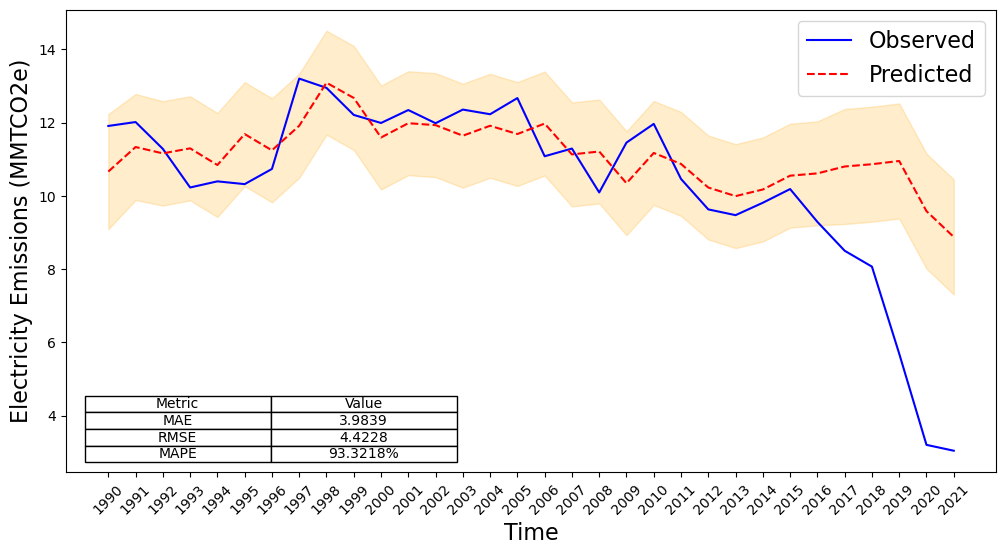

In [16]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the results with confidence bands
plt.figure(figsize=(12, 6))

#combine the test and train data together
concatenated_observed = pd.concat([elec_train,elec_test])

#combine the predicted test and train data together
concatenated_predicted = pd.concat([train_forecast_mean, test_forecast_df['Electricity GHG Emissions (MMTCO2e)']])

#combine the confidence interval of train and test data
concatenated_interval = pd.concat([train_conf_int, test_conf_int])


#plot the observed value
plt.plot(concatenated_observed.index, concatenated_observed, label='Observed', color='blue')


#plot the predicted value
plt.plot(concatenated_predicted.index, concatenated_predicted, label='Predicted', color='red', linestyle='--')



# Plot confidence bands for training data
plt.fill_between(concatenated_interval.index, concatenated_interval.iloc[:, 0], concatenated_interval.iloc[:, 1], color='orange', alpha=0.2)

#combine the index
combined_index = np.concatenate([elec_train.index, test_forecast_df.index])

# Adjust x-axis ticks and labels
plt.xticks(combined_index, rotation=45)

#plt.title('ARIMAx Model Forecast with Confidence Intervals', fontsize=18)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Electricity Emissions (MMTCO2e)', fontsize=16)
plt.legend(fontsize=16)

# Set x-axis and y-axis tick labels with fontsize
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#calculate the error term
# Extract the actual values for the test set
actual_values = df_test['Electricity GHG Emissions (MMTCO2e)']

# Extract the predicted values from the test forecast
predicted_values = test_forecast_df['Electricity GHG Emissions (MMTCO2e)']

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Calculate MAPE
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100


# Create a table inside the plot
table_data = [['Metric', 'Value'], 
              ['MAE', f'{mae:.4f}'], 
              ['RMSE', f'{rmse:.4f}'], 
              ['MAPE', f'{mape:.4f}%']]
table = plt.table(cellText=table_data, loc='lower left', cellLoc='center', colWidths=[0.2, 0.2])

plt.savefig('../../../figures/Report-images/arimax-electricity.png', dpi=600, bbox_inches='tight')

In [9]:
combined_index

array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021],
      dtype=int64)

In [10]:
train_forecast_mean

Year
1990    10.662559
1991    11.227318
1992    11.005475
1993    11.255812
1994    10.898179
1995    11.823640
1996    11.339496
1997    12.098482
1998    13.008572
1999    12.576031
2000    11.671064
2001    11.972928
2002    11.871606
2003    11.616675
2004    11.864193
2005    11.593892
2006    11.903062
2007    11.080914
2008    11.326095
2009    10.341756
2010    11.257840
2011    10.642993
2012    10.257009
2013    10.041974
2014    10.266744
2015    10.608275
Name: predicted_mean, dtype: float64

In [11]:
# Define the range of values for p, d, and q
p_values = range(3)  # Adjust the range based on your preferences
d_values = range(3)
q_values = range(3)

# Initialize a list to store the orders and corresponding AIC and BIC values
order_aic_bic_list = []

# Loop through all combinations of p, d, and q
for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        # Fit the model for the current combination
        mod = sm.tsa.arima.ARIMA(elec_train, order=(p, d, q), exog=exog_combined)
        res = mod.fit()

        # Store the order, AIC, and BIC values in the list
        order_aic_bic_list.append(((p, d, q), res.aic, res.bic))

    except Exception as e:
        # Handle any exceptions that might occur during model fitting
        print(f"Issue with order ({p}, {d}, {q}): {e}")

# Sort the list based on AIC values
order_aic_bic_list.sort(key=lambda x: (x[1], x[2]))

# Print the first five best orders and corresponding AIC and BIC values
for i, (order, aic, bic) in enumerate(order_aic_bic_list[:5]):
    print(f"Rank {i + 1} - Order: {order}, AIC: {aic}, BIC: {bic}")

C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\base\t

Rank 1 - Order: (0, 0, 1), AIC: 67.84574679877917, BIC: 74.13622948888658
Rank 2 - Order: (2, 0, 0), AIC: 68.50854750421087, BIC: 76.05712673233975
Rank 3 - Order: (1, 0, 0), AIC: 69.27976853683566, BIC: 75.57025122694307
Rank 4 - Order: (2, 0, 1), AIC: 69.43746841196543, BIC: 78.2441441781158
Rank 5 - Order: (1, 0, 1), AIC: 69.80344771236129, BIC: 77.35202694049019


C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\peiyaozhao\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
